# 02 — Parameter Sweep & Sensitivity (Almgren–Chriss)

This notebook runs **parameter sweeps** for the Almgren–Chriss (AC) optimal execution model to study how the schedule and costs change with:
- Risk aversion **λ**
- Volatility **σ**
- Temporary impact **η**
- Horizon **T**
- Grid choice (continuous vs. discrete)

**Outputs you'll get:**
- Efficient frontiers across λ
- Sensitivity curves for σ, η, and T
- Optional comparison between continuous and discrete grids
- A CSV export of all sweep results


In [1]:
# If you're running this from the `examples/` folder, add the repo root to Python path.
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ac.model import continuous_schedule, discrete_schedule
from ac.cost import continuous_cost, discrete_cost, efficient_frontier


In [2]:
# --- Base parameters (edit as needed) ---
X0_base    = 1_000_000   # shares (positive sell, negative buy)
T_base     = 1.0         # horizon in days (or your time unit)
sigma_base = 0.02        # volatility per sqrt(time)
eta_base   = 1e-6        # temporary impact (>0)
gamma_base = 1e-7        # permanent impact (>=0)

# Default grids
N_cont = 721             # points for 'continuous' integration
N_disc = 60              # slices for 'discrete' evaluation

print(f"Base params: X0={X0_base:,}, T={T_base}, sigma={sigma_base}, eta={eta_base}, gamma={gamma_base}")

Base params: X0=1,000,000, T=1.0, sigma=0.02, eta=1e-06, gamma=1e-07


In [3]:
def compute_point(lam, *, grid='continuous', X0=X0_base, T=T_base, sigma=sigma_base, eta=eta_base, gamma=gamma_base):
    if grid == 'continuous':
        cb, _ = continuous_cost(X0=X0, T=T, sigma=sigma, eta=eta, lam=float(lam), gamma=gamma, N=N_cont, return_schedule=False)
    elif grid == 'discrete':
        cb, _ = discrete_cost(X0=X0, T=T, sigma=sigma, eta=eta, lam=float(lam), gamma=gamma, N=N_disc, return_schedule=False)
    else:
        raise ValueError("grid must be 'continuous' or 'discrete'")
    return {
        'lambda': float(lam),
        'E_cost': float(cb.E_cost),
        'Var_cost': float(cb.Var_cost),
        'Objective': float(cb.objective),
        'kappa': float(cb.extras.get('kappa', np.nan)),
        'grid': grid,
        'X0': float(X0), 'T': float(T), 'sigma': float(sigma), 'eta': float(eta), 'gamma': float(gamma),
    }

## Sweep 1 — Efficient frontier across λ (continuous)

In [4]:
lams = np.logspace(-8, -4, 25)
front = efficient_frontier(X0=X0_base, T=T_base, sigma=sigma_base, eta=eta_base, gamma=gamma_base, lambdas=lams, grid='continuous', N=N_cont)
df_front = pd.DataFrame(front)
df_front.head()

,lambda,E_cost,Var_cost,objective,kappa
0,1.000000e-08,1.050000e+06,1.333334e+08,1.050001e+06,0.002000
1,1.467799e-08,1.050000e+06,1.333334e+08,1.050002e+06,0.002423
2,2.154435e-08,1.050000e+06,1.333333e+08,1.050003e+06,0.002936
3,3.162278e-08,1.050000e+06,1.333332e+08,1.050004e+06,0.003557
4,4.641589e-08,1.050000e+06,1.333331e+08,1.050006e+06,0.004309


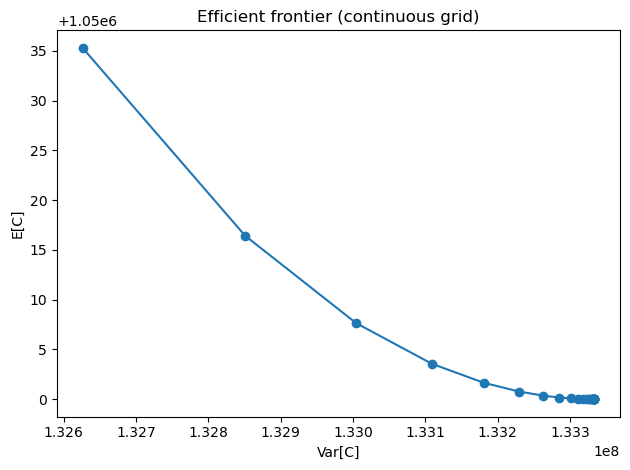

In [5]:
# Plot efficient frontier: Var on x-axis, E on y-axis
plt.figure()
plt.plot(df_front['Var_cost'], df_front['E_cost'], marker='o')
plt.xlabel('Var[C]')
plt.ylabel('E[C]')
plt.title('Efficient frontier (continuous grid)')
plt.tight_layout()
plt.show()

In [7]:
df_front

,lambda,E_cost,Var_cost,objective,kappa
0,1.000000e-08,1.050000e+06,1.333334e+08,1.050001e+06,0.002000
1,1.467799e-08,1.050000e+06,1.333334e+08,1.050002e+06,0.002423
2,2.154435e-08,1.050000e+06,1.333333e+08,1.050003e+06,0.002936
3,3.162278e-08,1.050000e+06,1.333332e+08,1.050004e+06,0.003557
4,4.641589e-08,1.050000e+06,1.333331e+08,1.050006e+06,0.004309
5,6.812921e-08,1.050000e+06,1.333330e+08,1.050009e+06,0.005220
6,1.000000e-07,1.050000e+06,1.333328e+08,1.050013e+06,0.006325
7,1.467799e-07,1.050000e+06,1.333324e+08,1.050020e+06,0.007662
8,2.154435e-07,1.050000e+06,1.333319e+08,1.050029e+06,0.009283
9,3.162278e-07,1.050000e+06,1.333312e+08,1.050042e+06,0.011247


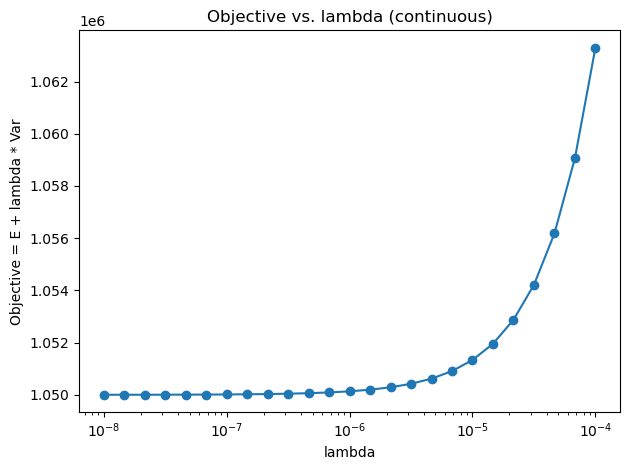

In [8]:
# Plot objective vs lambda
plt.figure()
plt.semilogx(df_front['lambda'], df_front['objective'], marker='o')
plt.xlabel('lambda')
plt.ylabel('Objective = E + lambda * Var')
plt.title('Objective vs. lambda (continuous)')
plt.tight_layout()
plt.show()

## Sweep 2 — Volatility sensitivity (σ)

In [9]:
sigmas = [0.01, 0.02, 0.03]
lams_sig = np.logspace(-8, -4, 25)
rows = []
for s in sigmas:
    for lam in lams_sig:
        rows.append(compute_point(lam, grid='continuous', sigma=s))
df_sigma = pd.DataFrame(rows)
df_sigma_pvt = df_sigma.pivot_table(index='lambda', columns='sigma', values='Objective')

df_sigma.head()

,lambda,E_cost,Var_cost,Objective,kappa,grid,X0,T,sigma,eta,gamma
0,1.000000e-08,1.050000e+06,3.333336e+07,1.050000e+06,0.001000,continuous,1000000.0,1.0,0.01,0.000001,1.000000e-07
1,1.467799e-08,1.050000e+06,3.333336e+07,1.050000e+06,0.001212,continuous,1000000.0,1.0,0.01,0.000001,1.000000e-07
2,2.154435e-08,1.050000e+06,3.333336e+07,1.050001e+06,0.001468,continuous,1000000.0,1.0,0.01,0.000001,1.000000e-07
3,3.162278e-08,1.050000e+06,3.333335e+07,1.050001e+06,0.001778,continuous,1000000.0,1.0,0.01,0.000001,1.000000e-07
4,4.641589e-08,1.050000e+06,3.333334e+07,1.050002e+06,0.002154,continuous,1000000.0,1.0,0.01,0.000001,1.000000e-07


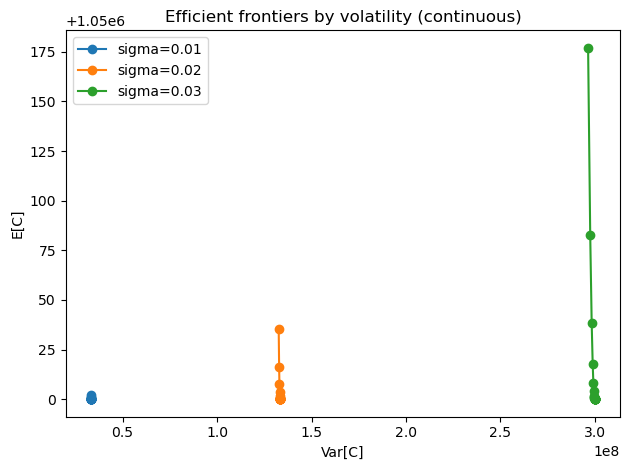

In [10]:
# Plot frontiers E vs Var for each sigma
plt.figure()
for s in sigmas:
    sub = df_sigma[df_sigma['sigma'] == s]
    sub_sorted = sub.sort_values('Var_cost')
    plt.plot(sub_sorted['Var_cost'], sub_sorted['E_cost'], marker='o', label=f'sigma={s}')
plt.legend()
plt.xlabel('Var[C]')
plt.ylabel('E[C]')
plt.title('Efficient frontiers by volatility (continuous)')
plt.tight_layout()
plt.show()

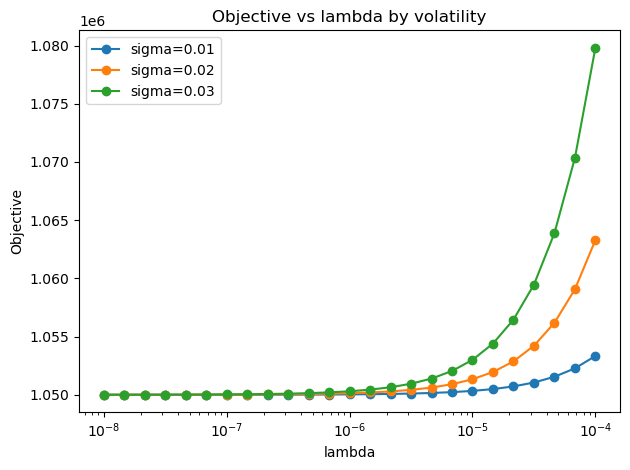

In [11]:
# Plot Objective vs lambda for each sigma
plt.figure()
for s in sigmas:
    sub = df_sigma[df_sigma['sigma'] == s].sort_values('lambda')
    plt.semilogx(sub['lambda'], sub['Objective'], marker='o', label=f'sigma={s}')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Objective')
plt.title('Objective vs lambda by volatility')
plt.tight_layout()
plt.show()

## Sweep 3 — Temporary impact sensitivity (η)

In [12]:
etas = [5e-7, 1e-6, 2e-6]
lams_eta = np.logspace(-8, -4, 25)
rows = []
for e in etas:
    for lam in lams_eta:
        rows.append(compute_point(lam, grid='continuous', eta=e))
df_eta = pd.DataFrame(rows)
df_eta.head()

,lambda,E_cost,Var_cost,Objective,kappa,grid,X0,T,sigma,eta,gamma
0,1.000000e-08,550000.000002,1.333333e+08,550001.333335,0.002828,continuous,1000000.0,1.0,0.02,5.000000e-07,1.000000e-07
1,1.467799e-08,550000.000003,1.333333e+08,550001.957068,0.003427,continuous,1000000.0,1.0,0.02,5.000000e-07,1.000000e-07
2,2.154435e-08,550000.000006,1.333332e+08,550002.872582,0.004152,continuous,1000000.0,1.0,0.02,5.000000e-07,1.000000e-07
3,3.162278e-08,550000.000011,1.333330e+08,550004.216371,0.005030,continuous,1000000.0,1.0,0.02,5.000000e-07,1.000000e-07
4,4.641589e-08,550000.000021,1.333328e+08,550006.188782,0.006094,continuous,1000000.0,1.0,0.02,5.000000e-07,1.000000e-07


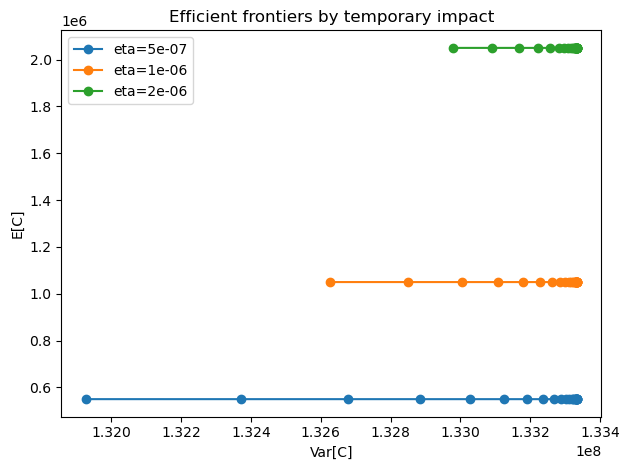

In [13]:
# Plot E vs Var per eta
plt.figure()
for e in etas:
    sub = df_eta[df_eta['eta'] == e].sort_values('Var_cost')
    plt.plot(sub['Var_cost'], sub['E_cost'], marker='o', label=f'eta={e:g}')
plt.legend()
plt.xlabel('Var[C]')
plt.ylabel('E[C]')
plt.title('Efficient frontiers by temporary impact')
plt.tight_layout()
plt.show()

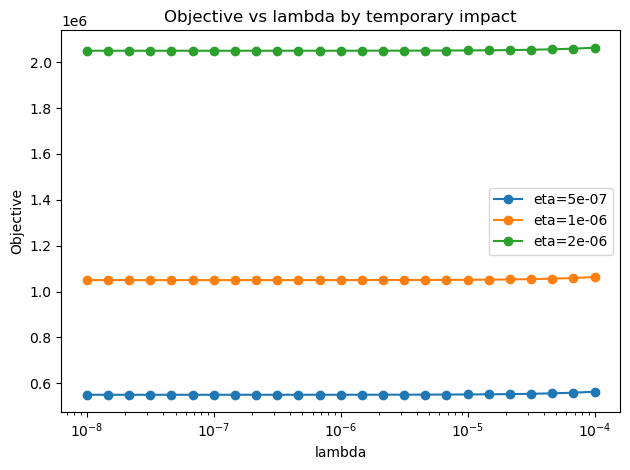

In [14]:
# Plot Objective vs lambda per eta
plt.figure()
for e in etas:
    sub = df_eta[df_eta['eta'] == e].sort_values('lambda')
    plt.semilogx(sub['lambda'], sub['Objective'], marker='o', label=f'eta={e:g}')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Objective')
plt.title('Objective vs lambda by temporary impact')
plt.tight_layout()
plt.show()

## Sweep 4 — Horizon sensitivity (T)

In [15]:
Ts = [0.5, 1.0, 2.0]
lams_T = np.logspace(-8, -4, 25)
rows = []
for T in Ts:
    for lam in lams_T:
        rows.append(compute_point(lam, grid='continuous', T=T))
df_T = pd.DataFrame(rows)
df_T.head()

,lambda,E_cost,Var_cost,Objective,kappa,grid,X0,T,sigma,eta,gamma
0,1.000000e-08,2.050000e+06,6.666672e+07,2.050001e+06,0.002000,continuous,1000000.0,0.5,0.02,0.000001,1.000000e-07
1,1.467799e-08,2.050000e+06,6.666672e+07,2.050001e+06,0.002423,continuous,1000000.0,0.5,0.02,0.000001,1.000000e-07
2,2.154435e-08,2.050000e+06,6.666671e+07,2.050001e+06,0.002936,continuous,1000000.0,0.5,0.02,0.000001,1.000000e-07
3,3.162278e-08,2.050000e+06,6.666670e+07,2.050002e+06,0.003557,continuous,1000000.0,0.5,0.02,0.000001,1.000000e-07
4,4.641589e-08,2.050000e+06,6.666669e+07,2.050003e+06,0.004309,continuous,1000000.0,0.5,0.02,0.000001,1.000000e-07


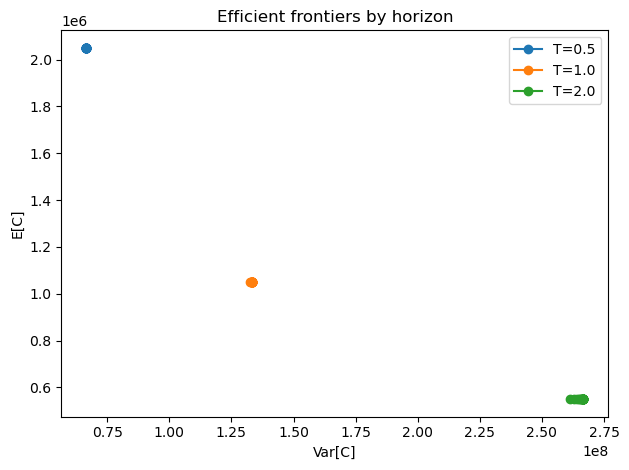

In [16]:
# Plot E vs Var per T
plt.figure()
for T in Ts:
    sub = df_T[df_T['T'] == T].sort_values('Var_cost')
    plt.plot(sub['Var_cost'], sub['E_cost'], marker='o', label=f'T={T}')
plt.legend()
plt.xlabel('Var[C]')
plt.ylabel('E[C]')
plt.title('Efficient frontiers by horizon')
plt.tight_layout()
plt.show()

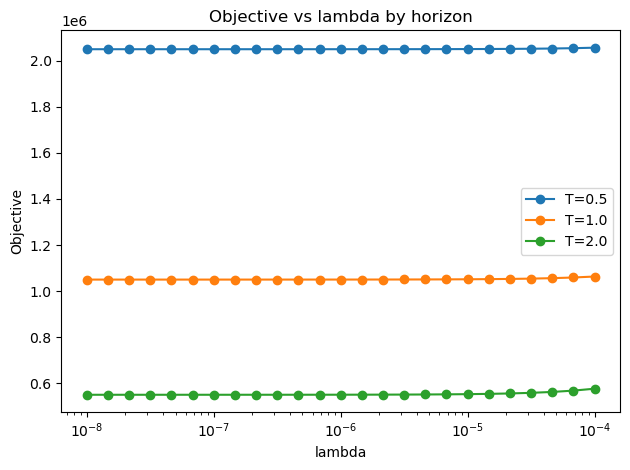

In [17]:
# Plot Objective vs lambda per T
plt.figure()
for T in Ts:
    sub = df_T[df_T['T'] == T].sort_values('lambda')
    plt.semilogx(sub['lambda'], sub['Objective'], marker='o', label=f'T={T}')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Objective')
plt.title('Objective vs lambda by horizon')
plt.tight_layout()
plt.show()

## Sweep 5 — Discrete vs Continuous comparison

In [18]:
lams_dc = np.logspace(-8, -4, 20)
rows = []
for lam in lams_dc:
    rows.append(compute_point(lam, grid='continuous'))
    rows.append(compute_point(lam, grid='discrete'))
df_dc = pd.DataFrame(rows)
df_dc.head()

,lambda,E_cost,Var_cost,Objective,kappa,grid,X0,T,sigma,eta,gamma
0,1.000000e-08,1.050000e+06,1.333334e+08,1.050001e+06,0.002000,continuous,1000000.0,1.0,0.02,0.000001,1.000000e-07
1,1.000000e-08,1.050000e+06,1.366851e+08,1.050001e+06,0.002000,discrete,1000000.0,1.0,0.02,0.000001,1.000000e-07
2,1.623777e-08,1.050000e+06,1.333333e+08,1.050002e+06,0.002549,continuous,1000000.0,1.0,0.02,0.000001,1.000000e-07
3,1.623777e-08,1.050000e+06,1.366851e+08,1.050002e+06,0.002549,discrete,1000000.0,1.0,0.02,0.000001,1.000000e-07
4,2.636651e-08,1.050000e+06,1.333333e+08,1.050004e+06,0.003248,continuous,1000000.0,1.0,0.02,0.000001,1.000000e-07


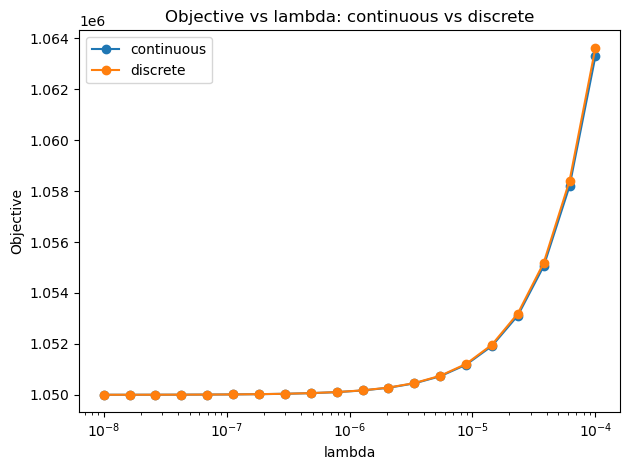

In [19]:
# Plot Objective vs lambda, continuous vs discrete
plt.figure()
for grid in ['continuous', 'discrete']:
    sub = df_dc[df_dc['grid'] == grid].sort_values('lambda')
    plt.semilogx(sub['lambda'], sub['Objective'], marker='o', label=grid)
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Objective')
plt.title('Objective vs lambda: continuous vs discrete')
plt.tight_layout()
plt.show()

## Save results to CSV

In [20]:
# Combine all sweeps and write to CSV
df_front['sweep'] = 'lambda_frontier'
df_sigma['sweep'] = 'sigma'
df_eta['sweep']   = 'eta'
df_T['sweep']     = 'T'
df_dc['sweep']    = 'disc_vs_cont'

df_all = pd.concat([df_front, df_sigma, df_eta, df_T, df_dc], ignore_index=True, sort=False)
csv_path = os.path.join(os.getcwd(), 'parameter_sweep_results.csv')
df_all.to_csv(csv_path, index=False)
csv_path

'c:\\Users\\jesus\\Desktop\\Kaggle\\examples\\parameter_sweep_results.csv'

### Notes & Tips

- The **shape** of the AC optimal trajectory is governed by \(\kappa = \sqrt{\lambda\,\sigma^2/\eta}\). Larger \(\lambda\) or \(\sigma\) or smaller \(\eta\) ⇒ more **front-loaded** trading.
- The **permanent impact** \(\gamma\) shifts expected cost but, in the baseline AC model here, it does not change the *shape* of the schedule.
- For very small \(\lambda\), the schedule approaches **TWAP** (risk-neutral limit), which this repo handles stably.
- You can increase `N_cont` and `N_disc` for higher numerical precision (with longer runtimes).
- To compare directly against heuristics (TWAP/POV), see `ac/schedules.py` for builders and profiles.
